Загружаем аудиофайл:

In [1]:
!wget https://download.samplelib.com/mp3/sample-9s.mp3

--2024-10-20 16:47:53--  https://download.samplelib.com/mp3/sample-9s.mp3
Resolving download.samplelib.com (download.samplelib.com)... 188.227.59.182
Connecting to download.samplelib.com (download.samplelib.com)|188.227.59.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154062 (150K) [audio/mpeg]
Saving to: 'sample-9s.mp3'

sample-9s.mp3       100%[===================>] 150.45K   740KB/s    in 0.2s    

2024-10-20 16:47:54 (740 KB/s) - 'sample-9s.mp3' saved [154062/154062]



In [2]:
%matplotlib inline  
import librosa
import librosa.display
import IPython
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
audio_data = 'sample-9s.mp3'
y, sr = librosa.load(audio_data)

Функция load считывает аудио-файл в виде временного рядя. Где, sr обозначает sample_rate.
Time series (временной ряд) представлен массивом.
sample_rate — это количество сэмплов на секунду аудио.
По умолчанию звук микшируется в моно. Но его можно передискретизировать во время загрузки до 22050 Гц. Это делается с помощью дополнительных параметров в функции librosa.load

In [4]:
print(type(y), type(sr))
print(y.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(211392,) 22050


## Амплитудно-временная форма

С помощью IPython.display можно проигрывать аудио в Jupyter Notebook, а с помощью display.waveshow формируются звуковые волны и мы можем посмотреть, как выглядит звук:

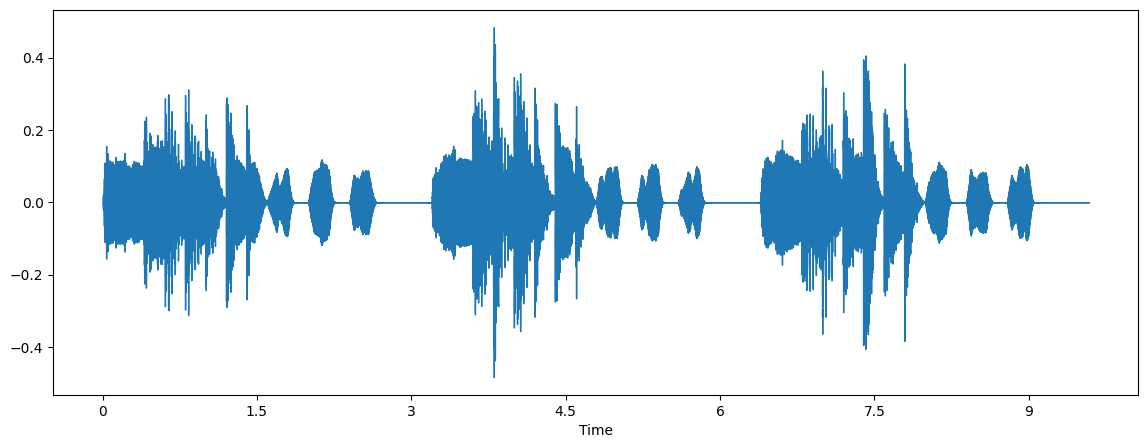

In [5]:
import IPython.display as ipd
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
ipd.Audio(audio_data)

## Преобразование Фурье

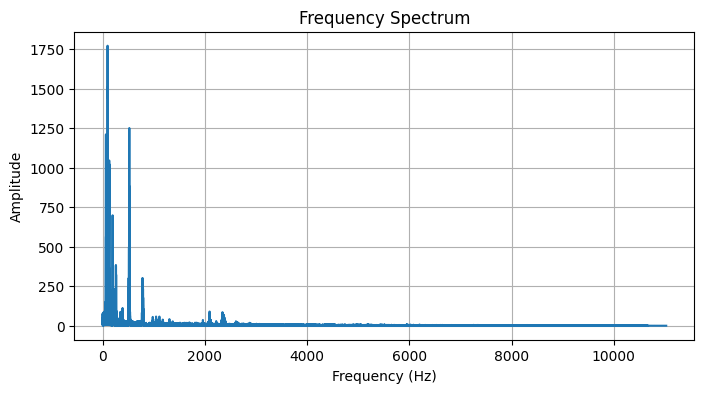

In [6]:
# Compute the FFT of the waveform
from scipy.fft import fft
spectrum = fft(y)
 
# Frequency bins
frequencies = np.fft.fftfreq(len(spectrum), 1 / sr)
 
# Plot the frequency spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(spectrum[:len(spectrum)//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum')
plt.grid(True)
plt.show()

## Спектрограмма

Спектрограмма - это визуальный способ представления уровня или “громкости” сигнала во времени на различных частотах, 
присутствующих в форме волны. Обычно изображается в виде тепловой карты. .stft() преобразует данные в кратковременное преобразование 
Фурье. С помощью STFT можно определить амплитуду различных частот, воспроизводимых в данный момент времени аудиосигнала.

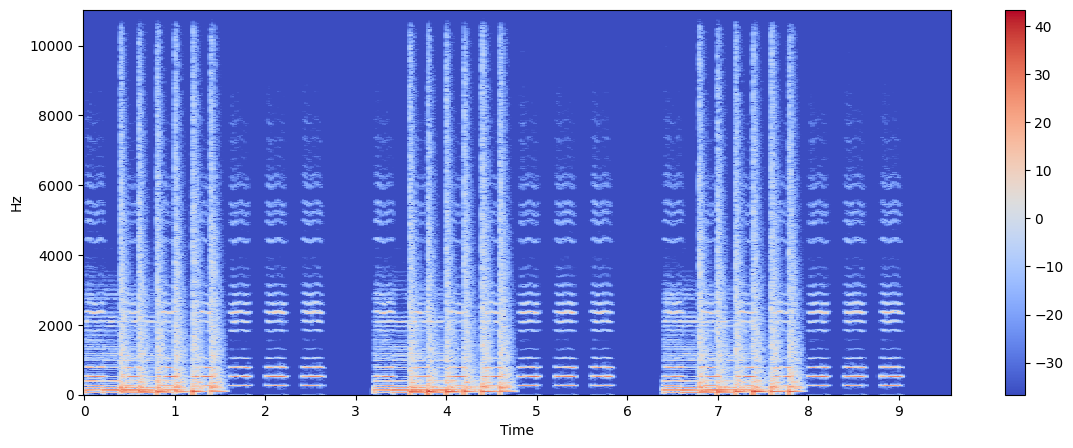

In [7]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

## Извлечение признаков из аудиофайла
У сэмпла есть несколько важных признаков. Есть фундаментальное понятие ритма в некоторых формах, а остальные либо имеют свою нюансы, либо связаны:

Темп: скорость, с которой паттерны повторяются. Темп измеряется в битах в минуту (BPM). Если у музыки 120 BPM, это значит, что каждую минуту в ней 120 битов (ударов).
Бит: отрезок времени. Это ритм, выстукиваемый в песне. Так, в одном такте 4 бита, например.
Такт: логичное деление битов. Обычно в такте 3 или 4 бита, хотя возможны и другие варианты.
Интервал: в программах для редактирования чаще всего встречаются интервалы. Обычно есть последовательность нот, например, 8 шестнадцатых одинаковой длины. Обычно интервал — 8 нот, триплеты или четверные.
Ритм: список музыкальных звуков. Все ноты и являются ритмом.

Detected Tempo: [151.99908088] beats/min
Bit nums: 18


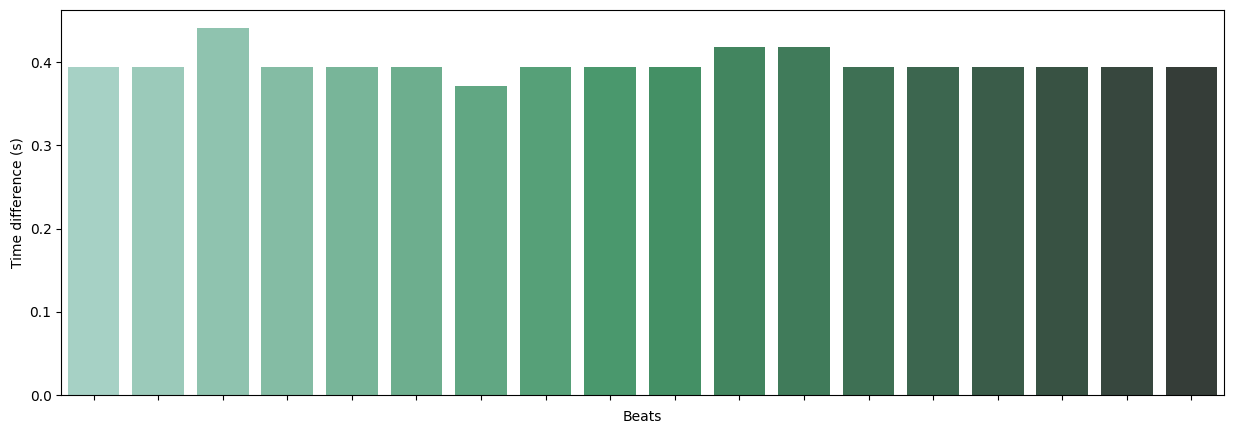

In [9]:
# Beat Extraction
y_harmonic, y_percussive = librosa.effects.hpss(y)
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,sr=sr)
print('Detected Tempo: '+str(tempo)+ ' beats/min')
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_time_diff=np.ediff1d(beat_times)
beat_nums = np.arange(1, np.size(beat_times))

print(f'Bit nums: {len(beat_nums)}')

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax.set_ylabel("Time difference (s)")
ax.set_xlabel("Beats")
g=sns.barplot({"beats": beat_nums, "times": beat_time_diff}, x="beats", y="times", palette="BuGn_d",ax=ax)
g=g.set(xticklabels=[])

Ошибка в выводе количества бит состояла в том, что вместо количества бит выводился массив, состоящий из номеров битов.

## Мел-кепстральные коэффициенты (MFCC)

Text(0.5, 1.0, 'MFCC')

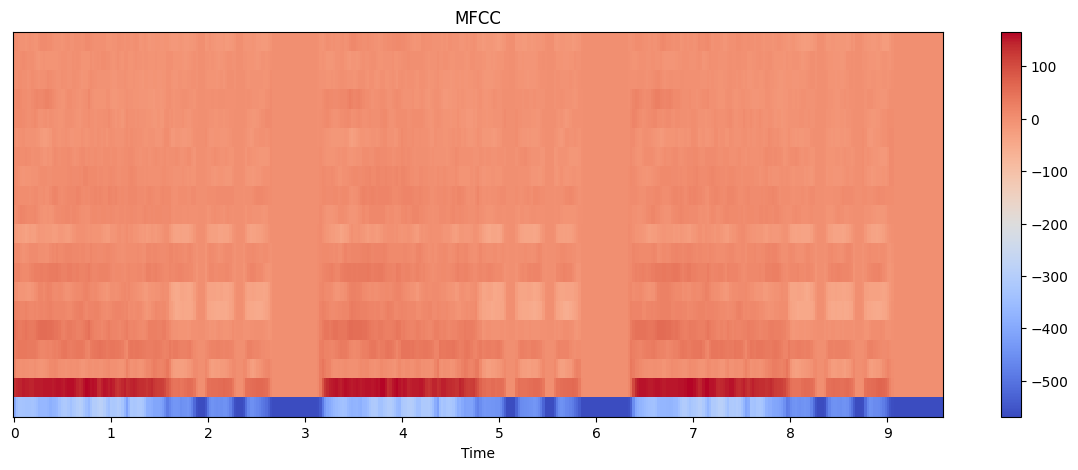

In [10]:
# Calculate MFCCs
mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=20)
plt.figure(figsize=(15, 5))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

In [11]:
mfccs

array([[-3.9635397e+02, -3.4738547e+02, -3.3288782e+02, ...,
        -5.6889716e+02, -5.6889716e+02, -5.6889716e+02],
       [ 1.3281320e+02,  1.4288403e+02,  1.4339874e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.4824844e+01, -1.8158996e-01, -2.5459728e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 2.3186152e+00,  3.3713651e-01,  3.4267831e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-7.7069700e-02,  5.3318608e-01, -2.6028051e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 4.6260719e+00,  4.1846185e+00, -2.5596449e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

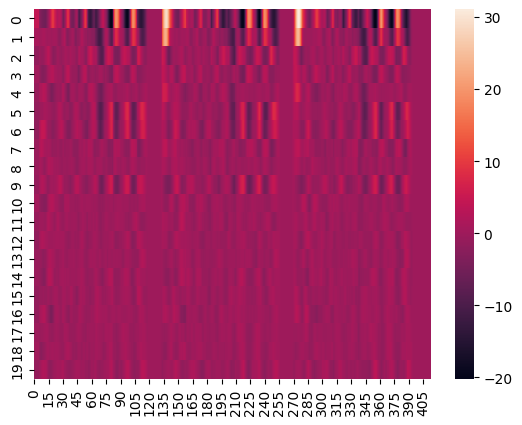

In [12]:
mfcc_delta = librosa.feature.delta(mfccs)
sns.heatmap(mfcc_delta)
plt.show()

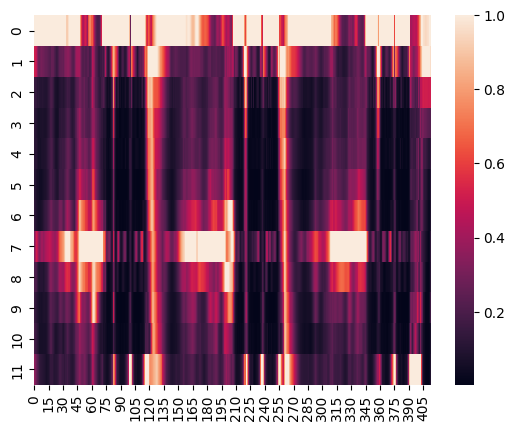

In [13]:
# нормализация в хромограмму
chromagram = librosa.feature.chroma_cqt(y=y, sr=sr)
sns.heatmap(chromagram)
plt.show()

## Спектральный центроид - Spectral Centroid.

Указывает, на какой частоте сосредоточена энергия спектра или, другими словами, указывает, где расположен “центр масс” для звука. 
librosa.feature.spectral_centroid вычисляет спектральный центроид для каждого фрейма в сигнале:

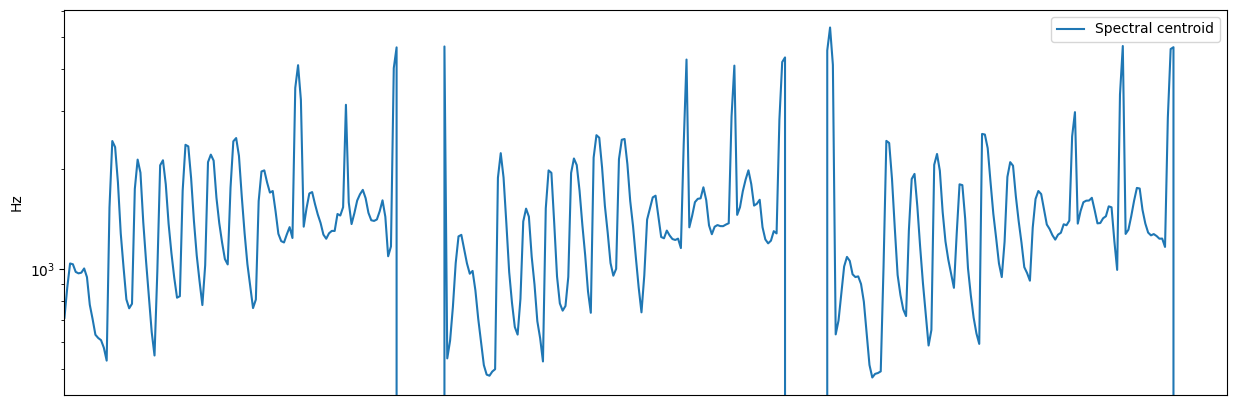

In [14]:
# Spectral Centroid
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
plt.figure(figsize=(15,5))
plt.subplot(1, 1, 1)
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, cent.shape[-1]])
plt.legend()

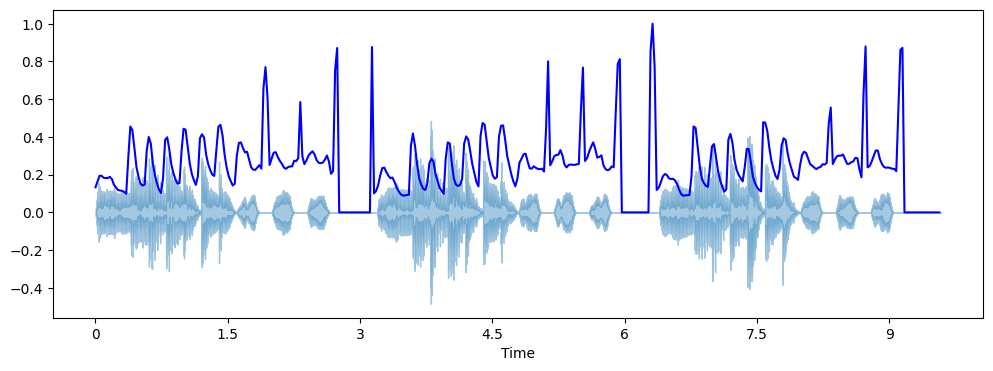

In [15]:
import sklearn
spectral_centroids = cent[0]
spectral_centroids.shape

# Вычисление временной переменной для визуализации
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Нормализация спектрального центроида для визуализации
def normalize(y, axis=0):
    return sklearn.preprocessing.minmax_scale(y, axis=axis)
# Построение спектрального центроида вместе с формой волны
librosa.display.waveshow(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

## Гармоническая и перкуссионная части сигнала

Гармоническая и перкуссионная части сигнала — это два компонента, которые помогают описать и анализировать звуковые сигналы.

Гармоническая часть сигнала включает в себя синусоидальные колебания, которые возникают в результате одновременного звучания нескольких частот, связанных определенными соотношениями (обычно кратными). Она создаёт «тело» звука и отвечает за его тональность и тембр. Гармонические звуки часто ассоциируются с музыкальными инструментами, где основная нота (фундаментальная частота) и ее обертоны создают богатую текстуру звука.

Перкуссионная часть сигнала, наоборот, связана с ударами, щелчками и другими резкими звуковыми эффектами, которые не имеют четкой гармонической структуры. Она важна для ритма и динамики. Перкуссионные звуки часто возникают при ударных инструментах, таких как барабаны, и служат для создания акцентов и движения в музыке.

Text(0.5, 1.0, 'Harmonic + Percussive')

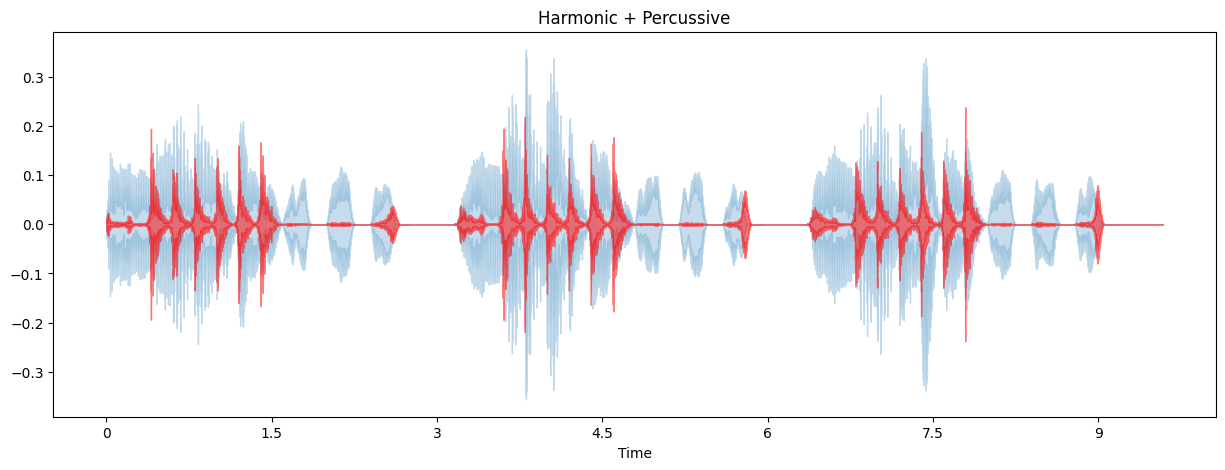

In [16]:
# Seperation of Harmonic and Percussive Signals
y_harmonic, y_percussive = librosa.effects.hpss(y)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y_harmonic, sr=sr, alpha=0.25)
librosa.display.waveshow(y_percussive, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')